In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
#Read train,test and sample_submission file by specifying the location
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [63]:
train.head()

,id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,1,b,18.42,10.415,y,p,aa,v,0.125,t,f,0,f,g,120.0,375,1
1,2,a,21.75,11.750,u,g,c,v,0.250,f,f,0,t,g,180.0,0,1
2,3,b,30.17,1.085,y,p,c,v,0.040,f,f,0,f,g,170.0,179,1
3,4,b,22.67,2.540,y,p,c,h,2.585,t,f,0,f,g,0.0,0,0
4,5,a,36.00,1.000,u,g,c,v,2.000,t,t,11,f,g,0.0,456,0


In [64]:
#Sample subsmission file format
sample.head()

,id,P
0,553,0
1,554,1
2,555,0
3,556,1
4,557,1


In [65]:
test.head()

,id,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O
0,553,b,29.17,3.500,u,g,w,v,3.500,t,t,3,t,g,329.0,0
1,554,b,28.33,5.000,u,g,w,v,11.000,t,f,0,t,g,70.0,0
2,555,b,29.25,14.790,u,g,aa,v,5.040,t,t,5,t,g,168.0,0
3,556,a,44.17,6.665,u,g,q,v,7.375,t,t,3,t,g,0.0,0
4,557,b,18.08,5.500,u,g,k,v,0.500,t,f,0,f,g,80.0,0


In [66]:
# Shape of training and test datasets
print ('Training dataset consists of {} rows with {} attributes'.format(train.shape[0], train.shape[1]-1))
# Shape of training and test datasets
print ('Testing dataset consists of {} rows.'.format(test.shape[0]))

Training dataset consists of 552 rows with 16 attributes
Testing dataset consists of 138 rows.


In [67]:
#Combine both train and test for all data transformations
combine = pd.concat([train,test], ignore_index=False )

In [68]:
del combine['E']

In [69]:
combine.shape

(690, 16)

In [70]:
combine.head()

,A,B,C,D,F,G,H,I,J,K,L,M,N,O,P,id
0,b,18.42,10.415,y,aa,v,0.125,t,f,0,f,g,120.0,375,1.0,1
1,a,21.75,11.750,u,c,v,0.250,f,f,0,t,g,180.0,0,1.0,2
2,b,30.17,1.085,y,c,v,0.040,f,f,0,f,g,170.0,179,1.0,3
3,b,22.67,2.540,y,c,h,2.585,t,f,0,f,g,0.0,0,0.0,4
4,a,36.00,1.000,u,c,v,2.000,t,t,11,f,g,0.0,456,0.0,5


In [71]:
combine['G'].isnull().sum()

9

In [72]:
#Categorical COlumns and no of unique values in each column
categories = ['A','D','F','G','I','J','L','M']

for i in categories:
    print('Category {} with {} unique values'.format(i,len(combine[i].unique())))

Category A with 3 unique values
Category D with 4 unique values
Category F with 15 unique values
Category G with 10 unique values
Category I with 2 unique values
Category J with 2 unique values
Category L with 2 unique values
Category M with 3 unique values


In [73]:
#train._get_numeric_data()

In [74]:
#Find frequecy of each unique value in Column A
combine['A'].value_counts()

b    468
a    210
Name: A, dtype: int64

In [75]:
#Find no of missing values in each column in Combine
combine.isnull().sum()

A      12
B      12
C       0
D       6
F       9
G       9
H       0
I       0
J       0
K       0
L       0
M       0
N      13
O       0
P     138
id      0
dtype: int64

# Feature Engineering

In [76]:
#Mode Imputation for Missing categorical Values

values = ['b','u','c','v','t','f','f','g']

j = 0
for i in categories:
    combine[i] = combine[i].apply(lambda x: values[j] if x!= x else x)
    j += 1

In [77]:
#Median Imputation for Numerical values

value = combine['B'].mean()
combine['B'] = combine['B'].apply(lambda x: value if x!= x else x)

value = combine['N'].mean()
combine['N'] = combine['N'].apply(lambda x: value if x!= x else x)

In [78]:
#Summy encoding for categorical variables
combine = pd.get_dummies(combine, columns=categories, drop_first=True)

In [79]:
#Explore and try to build some new features

from math import log,sqrt,sin,exp

combine['new2'] = 1/combine['B']

#combine['new3'] = np.exp(combine['H'])

combine['new4'] = combine.apply(lambda x: (x['O']/x['B']) if x['B'] != 0  else 0,axis=1)

combine['new5'] = combine['O'].apply(lambda x: log(x) if x != 0  else -20)

combine['new6'] = combine.apply(lambda x: x['N']/exp(x['K']),axis=1)

combine['new1'] = combine['N'].apply(lambda x: sin(x) if x > 0  else 0)

combine['new7'] = combine.apply(lambda x: (x['B']-x['C'])/exp(x['H']),axis=1)

#combine['new8'] = combine.apply(lambda x: sqrt(abs(x['O']-x['N'])) ,axis=1)
#test['new8'] = test.apply(lambda x: sqrt(abs(x['O']-x['N']))  ,axis=1)

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combine[['B', 'C', 'H', 'N','O','new1','new2','new4','new5','new6','new7']] = scaler.fit_transform(combine[['B', 'C', 'H', 'N','O','new1','new2','new4','new5','new6','new7']])

In [81]:
a  = train.shape[0]

del train,test

train = combine[:a]
test = combine[a:]
del combine

In [82]:
output = train['P']
train.drop('P',axis=1,inplace=True)
test.drop('P',axis=1,inplace=True)

In [83]:
numerical_categories = ['B','C','H','K','N','O']

for i in numerical_categories:
    print(i,train[i].corr(output))

B -0.163345165491
C -0.199470863548
H -0.325125230178
K -0.438025515676
N 0.114773508579
O -0.172350574018


In [84]:
for i in train.columns:
    for j in train.columns:
        if i!= j and train[i].corr(train[j])>0.5:
            print(i,j,train[i].corr(train[j]))

K J_t 0.631871928948
N new6 0.719131296491
O G_o 0.51326758015
O new4 0.943367152386
F_e G_z 0.617284177143
F_ff G_ff 0.939531756204
F_j G_j 0.718246131106
G_ff F_ff 0.939531756204
G_j F_j 0.718246131106
G_o O 0.51326758015
G_o new4 0.630104729226
G_z F_e 0.617284177143
J_t K 0.631871928948
new4 O 0.943367152386
new4 G_o 0.630104729226
new6 N 0.719131296491


In [85]:
train.head()

,B,C,H,K,N,O,id,A_b,D_u,D_y,...,J_t,L_t,M_p,M_s,new2,new4,new5,new6,new1,new7
0,0.070226,0.371964,0.004386,0,0.060,0.00375,1,1,0,1,...,0,0,0,0,0.694050,0.003563,0.822739,0.103448,0.790377,0.152003
1,0.120301,0.419643,0.008772,0,0.090,0.00000,2,0,1,0,...,0,1,0,0,0.556132,0.000000,0.000000,0.155172,0.099326,0.161514
2,0.246917,0.038750,0.001404,0,0.085,0.00179,3,1,0,1,...,0,0,0,0,0.343218,0.001038,0.799272,0.146552,0.673368,0.426453
3,0.134135,0.090714,0.090702,0,0.000,0.00000,4,1,0,1,...,0,0,0,0,0.525172,0.000000,0.000000,0.000000,0.500000,0.079097
4,0.334586,0.035714,0.070175,11,0.000,0.00456,5,0,1,0,...,1,0,0,0,0.254151,0.002217,0.828945,0.000000,0.500000,0.121408


# Feature Importance

Feature ranking:
1. B feature 7 (0.038931)
2. C feature 0 (0.041544)
3. H feature 6 (0.049982)
4. N feature 4 (0.051857)
5. O feature 3 (0.052059)
6. id feature 9 (0.057216)
7. new1 feature 1 (0.074019)
8. new2 feature 5 (0.076052)
9. new4 feature 8 (0.081762)
10. new5 feature 2 (0.099885)
11. new6 feature 11 (0.136430)
12. new7 feature 10 (0.240263)


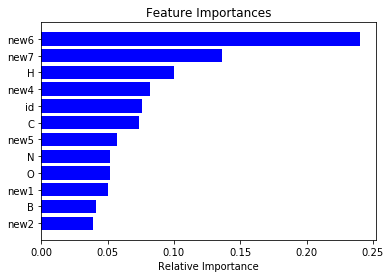

In [86]:
#See if new features are important

cate = ['B','C','H','N','O','id','new1','new2','new4','new5','new6','new7']

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Build a forest and compute the feature importances
forest = RandomForestRegressor(n_estimators=250,random_state=0)

forest.fit(train[cate], output)
importances = forest.feature_importances_
indices = np.argsort(importances)

features = train[cate].columns

# Print the feature ranking
print("Feature ranking:")

for f in range(train[cate].shape[1]):
    print("%d. %s feature %d (%f)" % (f + 1, features[f],indices[f], importances[indices[f]]))


plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()


In [87]:
train_id = train['id']
test_id = test['id']

In [88]:
final_train = np.array(train)
final_test = np.array(test)

In [89]:
from sklearn import preprocessing
final_train = preprocessing.scale(final_train)
final_test = preprocessing.scale(final_test)

# Logistiic Regression with Grid search

In [90]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV


In [91]:
grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
         , 'solver': ['newton-cg','lbfgs', 'liblinear', 'sag'],
        'tol' : [10 ,5 ,20]
    }

clf = LogisticRegression(random_state=777, max_iter=10000 ,penalty = 'l2')
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=fold)
gs.fit(final_train, output)

print ('gs.best_score_:', gs.best_score_)
print ('gs.best_params_:', gs.best_params_)

gs.best_score_: 0.8605072463768116
gs.best_params_: {'solver': 'sag', 'tol': 10, 'C': 0.1}


In [92]:
preds = gs.predict(final_test)

sub = pd.DataFrame()
sub['id'] = test_id
sub['P'] = preds

sub['P'] = sub['P'].apply(lambda x: int(x))

sub.to_csv("logistic_grid.csv",index=False) 

# SVM with Grid search

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the dataset in two equal parts
#X_train, X_test, y_train, y_test = train_test_split(
#    train, output, test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],'degree':[3,4,6]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000],'gamma': [1e-3, 1e-4]}]

In [92]:
score = 'accuracy'

print("# Tuning hyper-parameters for accuracy" )
print()
    
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='accuracy' )
clf.fit(X_train, output)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

# Tuning hyper-parameters for accuracy

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [143]:
#Try with SVM

from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(kernel='rbf', C=10 ,gamma=0.0001 ,degree = 3)

scores = cross_val_score(clf, final_train, output, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))  


Accuracy: 0.87 (+/- 0.05)


In [145]:
clf.fit(final_train, output)
pred = clf.predict(final_test)

sub = pd.DataFrame()
sub['id'] = test_id
sub['P'] = pred

sub['P'] = sub['P'].apply(lambda x: int(x))

sub.to_csv("svm_rbf.csv",index=False) 

In [146]:
clf = svm.SVC(kernel='linear', C=1 ,gamma=0.001 )

clf.fit(final_train, output)
pred = clf.predict(final_test)

sub = pd.DataFrame()
sub['id'] = test_id
sub['P'] = pred

sub['P'] = sub['P'].apply(lambda x: int(x))

sub.to_csv("svm_linear.csv",index=False) 

In [93]:
#Xgboost

import xgboost as xgb

xgb_params = {
    'objective':'binary:logistic',
    'eval_metric':'error',
    'eta':0.05,
    'max_depth':8,
    'subsample':0.8,
    'colsample_bytree':0.8,
    'min_child_weight':4
}

nrounds = 2500 
kfolds = 5  

In [94]:
#Cross validation score

from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import gc

best=[]
score=[]

oof_train=pd.DataFrame({'id':train_id, 'P':0})

kfolds = 5
nrounds = 2500

strain = train

skf = SKF( n_splits=kfolds, shuffle=True,random_state=123)

i=0

for train_index, test_index in skf.split(train, output):
    
    print('Fold {0}'.format(i + 1))
    X_train, X_val = train.iloc[train_index], train.iloc[test_index]
    y_train, y_val = output[train_index],output[test_index]

    dtrain = xgb.DMatrix(X_train,y_train)
    dval = xgb.DMatrix(X_val,y_val)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]

    gbdt = xgb.train(xgb_params, dtrain, nrounds, watchlist,verbose_eval=50,early_stopping_rounds=25)  
    
    bst=gbdt.best_ntree_limit
    pred=gbdt.predict(dval, ntree_limit=bst)
    oof_train.loc[test_index,"P"]= pred
    
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
            
    scr=accuracy_score(y_val,pred) 
    
    best.append(bst)    
    score.append(scr)
    i+=1
    
    del dtrain
    del dval
    del gbdt
    gc.collect()
    
print(score)

Fold 1
[0]	train-error:0.126984	eval-error:0.144144
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 25 rounds.
Stopping. Best iteration:
[0]	train-error:0.126984	eval-error:0.144144

Fold 112
[0]	train-error:0.126984	eval-error:0.18018
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 25 rounds.
Stopping. Best iteration:
[4]	train-error:0.099773	eval-error:0.144144

Fold 112
[0]	train-error:0.124434	eval-error:0.145455
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 25 rounds.
[50]	train-error:0.074661	eval-error:0.063636
Stopping. Best iteration:
[43]	train-error:0.081448	eval-error:0.063636

Fold 111
[0]	train-error:0.122172	eval-error:0.154545
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Wi

In [95]:
#Final output based on parameters obtained from CV.

dtest=xgb.DMatrix(test)

best_nrounds=int(round(np.mean(best)))

dtrain=xgb.DMatrix(train,output)

watchlist = [(dtrain, 'train')]
gbdt = xgb.train(xgb_params, dtrain, best_nrounds,watchlist,verbose_eval=50,early_stopping_rounds=25)

pred=gbdt.predict(dtest)

value = []
count = 0
for i in pred:
    if i >= 0.5:
        value.append(1)
        count += 1
    else:
        value.append(0)

print(count)

sub = pd.DataFrame()
sub['id'] = test_id
sub['P'] = pred

sub['P'] = [1 if x >= 0.5 else 0 for x in sub['P']]

sub.to_csv("xgboost_label.csv",index=False) 

[0]	train-error:0.112319
Will train until train-error hasn't improved in 25 rounds.
77


# Grid search for XGBOOST

In [96]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))


In [97]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1,3, 4, 5, 10],
        'gamma':  [ 1.5, 2 ],
        'subsample': [ 0.7, 0.8, 0.9],
        'colsample_bytree': [ 0.7, 0.8, 0.9],
        'max_depth': [3, 4, 5,6 ,8],
        'learning_rate' : [ 0.02, 0.05, 0.15, 0.1 ]
        }

In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold as skf
from datetime import datetime

xgb = XGBClassifier( n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [ ]:
tryf = skf.split(train,output)
tryf

In [107]:
skf = SKF( n_splits=5, shuffle=True,random_state=123)
y = output.values.ravel()

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='accuracy', n_jobs=4, cv = skf.split(train,y), verbose=3 )

grid.fit(train, output)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.909091, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma

[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s


[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    1.0s


[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1

[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsamp

[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.864865, total=   0.

[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.936364, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsampl

[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.854545, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, sub

[Parallel(n_jobs=4)]: Done 440 tasks      | elapsed:    9.9s


[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.855856, total=   0.

[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=4, subsam

[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=

[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsam

[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=

[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.0s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=6, sub

[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=8, subsample=

[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV] max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=8, subsampl

[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.900901, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=3, subsample

[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.792793, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=

[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=

[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=

[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.0s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsampl

[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.882883, total=   0.1s
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.792793, total=   0.

[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.0s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.0s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, s

[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV]  max_depth=6, subsample

[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.0s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.0s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.900000, total=   0.0s
[CV] max_depth=6, su

[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=

[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:   25.8s


[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.801802, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.891892, total=   0.1s
[CV] max_depth=8, subsample=

[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.900901, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.

[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min

[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=

[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.7, min

[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV]  max_depth=4, subsample=0.9

[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.9, min

[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.9, mi

[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=6, subsample=0.8, min

[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.7, min

[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.2s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.8, min

[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV] max_depth=8, subsample=0.7, min

[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.7, min

[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_

[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_c

[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_

[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_ch

[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_

[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child

[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_

[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_w

[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_

[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_w

[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.819820, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.873874, total=   0.0s
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.0s
[CV] max_dep

[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.855856, total=   0.0s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.0s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.873874, total=   0.0s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_

[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.0s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.918182, total=   0.0s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.0s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_chi

[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_

[Parallel(n_jobs=4)]: Done 1976 tasks      | elapsed:   46.5s


[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_w

[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child

[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.2s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.2s
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.2s
[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.918182, total=   0.2s
[CV] max_depth=5, subsample=0.8, min_child_w

[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_c

[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_w

[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_

[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_w

[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min

[CV] max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_w

[CV]  max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.900000, total=   0.0s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_ch

[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.8, min_child_w

[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_w

[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_

[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_w

[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_chil

[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.801802, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_w

[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.801802, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_

[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.801802, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_

[CV] max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min

[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3

[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weig

[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3,

[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=

[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3,

[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5,

[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3,

[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learnin

[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1

[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5

[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.7, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min

[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=

[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subs

[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV] max_depth=4, subsample=

[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.927273, total=   0.1s
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=4, subsam

[Parallel(n_jobs=4)]: Done 3128 tasks      | elapsed:  1.3min


[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, sub

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.936364, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, su

[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.936364, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsam

[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.2s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.836364, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample

[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsa

[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.918182, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsampl

[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsa

[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, sub

[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, sub

[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsamp

[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.836364, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.891892, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsampl

[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.891892, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample

[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, col

[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, su

[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample

[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsa

[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=

[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=6, subsampl

[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=

[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=

[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV]  max_depth=3, subsample=0.8, mi

[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min

[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.900901, total=   0.1s
[CV] max_depth=4, subsample=0.7, 

[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.9, min

[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=

[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.801802, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.7, min

[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=

[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.8, min

[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=6, subsample=0.7, 

[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.836364, total=   0.2s
[CV] max_depth=8, subsample=0.9, min

[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.8, min

[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_w

[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8,

[Parallel(n_jobs=4)]: Done 4536 tasks      | elapsed:  1.9min


[CV]  max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child

[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_w

[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_

[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_

[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.936364, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_w

[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child

[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_w

[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_c

[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_

[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.02, gamma=2 
[CV] max_depth=8, subsample=0.8, min_ch

[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.900000, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_

[CV]  max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_chil

[CV]  max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_

[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_w

[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.819820, total=   0.1s
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_

[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_w

[CV]  max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.900000, total=   0.1s
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child

[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_w

[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_c

[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_w

[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min

[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_w

[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_

[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_w

[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.828829, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.810811, total=   0.1s
[CV] max_de

[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_w

[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child

[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_w

[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_

[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_w

[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_

[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.864865, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child

[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.845455, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4,

[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_we

[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=4

[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.801802, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weig

[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4,

[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight

[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3,

[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5

[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3,

[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.8, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5,

[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.

[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsa

[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.936364, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=4, su

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 


[Parallel(n_jobs=4)]: Done 6200 tasks      | elapsed:  2.6min


[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=5, subs

[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.836364, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=  

[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.828829, total=   0.2s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.836364, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.890909, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsamp

[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=4, sub

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=5, sub

[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=6, subsamp

[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.873874, total=   0.2s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.900901, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.891892, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsample

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=3, subsamp

[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.891892, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample

[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.801802, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=4, s

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.836364, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample

[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=5, subs

[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample

[CV]  max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=6, subsamp

[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.846847, total=   0.1s
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=1.5 
[CV]  max_depth=8, subsample

[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.810811, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.7, mi

[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.891892, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] 

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=3, subsample=0.9

[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.9, mi

[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.828829, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=4, subsample=0.

[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.836364, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, mi

[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.819820, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=5, subsample=0

[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.900000, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, mi

[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.801802, total=   0.1s
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=6, subsample=0.9, m

[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.845455, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.890909, total=   0.2s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.855856, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.837838, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, mi

[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.854545, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5 
[CV]  max_depth=8, subsample=0.8, mi

[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=1.5, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_chil

[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_w

[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_ch

[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.936364, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_

[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=4, subsample=0.9, min

[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_w

[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_c

[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.836364, total=   0.2s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV] max_depth=6, subsample=0.9, min_child_w

[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_chil

[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.836364, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_w

[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.02, gamma=2, score=0.855856, total=   0.1s
[CV] max_dept

[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV]  max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV]  max_depth=3, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_

[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_w

[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_w

[CV]  max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.918182, total=   0.1s
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV] max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_

[CV] max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_chi

[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.837838, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.855856, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.855856, total=   0.1s
[CV] max_dept

[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_ch

[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_

[Parallel(n_jobs=4)]: Done 8120 tasks      | elapsed:  3.3min


[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_

[CV] max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_

[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_

[CV] max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.873874, total=   0.2s
[CV] max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.828829, total=   0.1s
[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.05, gamma=2, score=0.855856, total=   0.2s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=8, subsample=0.9, min_c

[CV]  max_depth=3, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_

[CV] max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.873874, total=   0.1s
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_ch

[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.837838, total=   0.1s
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9,

[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child

[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.846847, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.836364, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_

[CV] max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV]  max_depth=5, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=5, subsample=0.9, min_child_

[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.2s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.1s
[CV]  max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV] max_depth=6, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.890909, total=   0.2s
[CV] max_depth=6, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_

[CV] max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_w

[CV]  max_depth=6, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.864865, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.854545, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_chil

[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.827273, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=8, subsample=0.8, min_child_w

[CV]  max_depth=8, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.828829, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.15, gamma=2, score=0.881818, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child

[CV] max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.891892, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.819820, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=4,

[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=3, subsample=0.9, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=3, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=3, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=3, subsample=0.8, min_child_w

[CV] max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.845455, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=3,

[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=4, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=4, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=4, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=4, subsample=0.8, min_child_weight

[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.873874, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.810811, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=3,

[CV] max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.863636, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.927273, total=   0.1s
[CV] max_depth=5, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=5, subsample=0.8, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=5, subsample=0.7, min_child_weight=10, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.909091, total=   0.1s
[CV] max_depth=5, subsample=0.7, min_child_weight

[CV] max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.890909, total=   0.2s
[CV] max_depth=6, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.828829, total=   0.1s
[CV]  max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV] max_depth=6, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.900000, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=3,

[CV] max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.836364, total=   0.1s
[CV] max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.872727, total=   0.1s
[CV] max_depth=6, subsample=0.9, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=6, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.864865, total=   0.1s
[CV] max_depth=6, subsample=0.8, min_child_weight=5,

[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.854545, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.8, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.882883, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.909091, total=   0.2s
[CV] max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=1, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.819820, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=3,

[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.819820, total=   0.2s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.918182, total=   0.1s
[CV] max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.9, min_child_weight=4, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.900000, total=   0.2s
[CV] max_depth=8, subsample=0.8, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2 
[CV]  max_depth=8, subsample=0.7, min_child_weight=5, colsample_bytree=0.9, learning_rate=0.1, gamma=2, score=0.882883, total=   0.1s
[CV] max_depth=8, subsample=0.9, min_child_weight=5,

[Parallel(n_jobs=4)]: Done 9000 out of 9000 | elapsed:  3.8min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fb8f061b0a0>,
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [3, 4, 5, 6, 8], 'learning_rate': [0.02, 0.05, 0.15, 0.1], 'min_child_weight': [1, 3, 4, 5, 10], 'colsample_bytree': [0.7, 0.8, 0.9], 'subsample': [0.7, 0.8, 0.9], 'gamma': [1.5, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=3)

In [108]:
#print(grid.cv_results_)
#print('\n Best estimator:')
#print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ )
print('\n Best parameters:')
print(grid.best_params_)

y_test = grid.best_estimator_.predict(test)

sub = pd.DataFrame()
sub['id'] = test_id
sub['P'] = y_test
sub['P'] = [1 if x >= 0.5 else 0 for x in sub['P']]

#sub.to_csv("submission_grid_search.csv",index=False) 



 Best score:
0.88768115942

 Best parameters:
{'max_depth': 4, 'subsample': 0.8, 'min_child_weight': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'gamma': 1.5}
